In [2]:
import pandas as pd
import earthaccess
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

auth = earthaccess.login(persist=True)

# Area of Interest (min_lon, min_lat, max_lon, max_lat = bbox)
bbox = (3.856667, 3.956111, 7.049167, 9.040000)

#start date and end date (dynamic)
start_date = "2024-03-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

granules = earthaccess.search_data(
    short_name="PACE_OCI_L3M_LANDVI",
    temporal=("2024-03-05", "2026-01-28"),
    granule_name="*.MO.*.4km.*",   
    count=200
)

In [3]:
len(granules)

21

In [4]:
for i, granule in enumerate(granules):
    print(f"{i+1}. {granule}")


1. Collection: {'Version': '3.1', 'ShortName': 'PACE_OCI_L3M_LANDVI'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 90, 'SouthBoundingCoordinate': -90, 'WestBoundingCoordinate': -180}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-03-31T23:59:59Z', 'BeginningDateTime': '2024-03-05T00:00:00Z'}}
Size(MB): 317.3418445587158
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240301_20240331.L3m.MO.LANDVI.V3_1.4km.nc']
2. Collection: {'ShortName': 'PACE_OCI_L3M_LANDVI', 'Version': '3.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'SouthBoundingCoordinate': -90, 'NorthBoundingCoordinate': 90, 'WestBoundingCoordinate': -180, 'EastBoundingCoordinate': 180}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-04-01T00:00:00Z', 'EndingDateTime': '2024-04-30T23:59:59Z'}}
Size(MB): 278.579261779

In [5]:
# Download and load the data files
files = earthaccess.open(granules)
print(f"Loaded {len(files)} files")
print(f"First file: {files[0]}")

# Load datasets with xarray
print("Loading datasets with xarray...")
datasets = [xr.open_dataset(f) for f in files]
print(f"Loaded {len(datasets)} datasets with xarray")


QUEUEING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/21 [00:00<?, ?it/s]

Loaded 21 files
First file: <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240301_20240331.L3m.MO.LANDVI.V3_1.4km.nc>
Loading datasets with xarray...
Loaded 21 datasets with xarray


In [7]:
# Let's look at the structure of the first dataset
ds_first = datasets[0]
print("Variables in first dataset:")
print(ds_first.data_vars)
print("\nDataset info:")
print(ds_first)


Variables in first dataset:
Data variables:
    ndvi     (lat, lon) float32 149MB ...
    evi      (lat, lon) float32 149MB ...
    ndwi     (lat, lon) float32 149MB ...
    ndii     (lat, lon) float32 149MB ...
    cci      (lat, lon) float32 149MB ...
    ndsi     (lat, lon) float32 149MB ...
    pri      (lat, lon) float32 149MB ...
    cire     (lat, lon) float32 149MB ...
    car      (lat, lon) float32 149MB ...
    mari     (lat, lon) float32 149MB ...
    palette  (rgb, eightbitcolor) uint8 768B ...

Dataset info:
<xarray.Dataset> Size: 1GB
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    ndvi     (lat, lon) float32 149MB ...
    evi      (lat, lon) float32 149MB ...
    ndwi     (lat, lon) float32 149MB ...
    ndii     (lat, lo

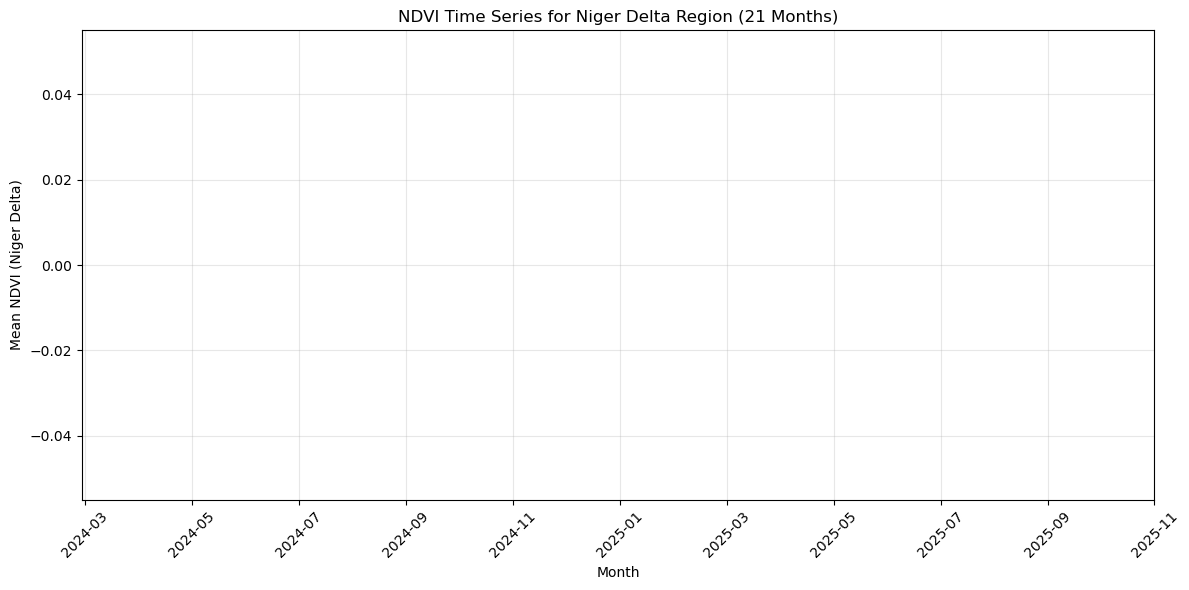

NDVI Time Series (Mean values):
2024-03: nan
2024-04: nan
2024-05: nan
2024-06: nan
2024-07: nan
2024-08: nan
2024-09: nan
2024-10: nan
2024-11: nan
2024-12: nan
2025-01: nan
2025-02: nan
2025-03: nan
2025-04: nan
2025-05: nan
2025-06: nan
2025-07: nan
2025-08: nan
2025-09: nan
2025-10: nan
2025-11: nan


In [8]:
# Subset data to Niger Delta region (bbox = 3.86°E, 3.96°N, 7.05°E, 9.04°N)
# Extract and aggregate NDVI values over the region for time series

ndvi_timeseries = []
months = []

for idx, ds in enumerate(datasets):
    # Subset to Niger Delta bounding box
    ds_subset = ds.sel(lon=slice(bbox[0], bbox[2]), lat=slice(bbox[1], bbox[3]))
    
    # Calculate mean NDVI over the region
    mean_ndvi = ds_subset['ndvi'].mean().values
    ndvi_timeseries.append(mean_ndvi)
    
    # Extract month from product name
    product_name = ds.attrs.get('product_name', '')
    if 'PACE_OCI' in product_name:
        date_str = product_name.split('.')[1]
        month = f"{date_str[:4]}-{date_str[4:6]}"
    else:
        month = f"Month {idx+1}"
    months.append(month)

# Plot time series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(len(ndvi_timeseries)), ndvi_timeseries, marker='o', linewidth=2, markersize=6)
ax.set_xticks(range(0, len(ndvi_timeseries), 2))
ax.set_xticklabels(months[::2], rotation=45)
ax.set_xlabel('Month')
ax.set_ylabel('Mean NDVI (Niger Delta)')
ax.set_title('NDVI Time Series for Niger Delta Region (21 Months)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"NDVI Time Series (Mean values):")
for month, value in zip(months, ndvi_timeseries):
    print(f"{month}: {value:.2f}")